 # Beyond the basics

 ## Nonlinearity

A nonlinear term in a diffusive problem is usually straightforward to fold into the semidiscretization process. Here is the solution of 

$$
\partial_t u = 0.1\partial_{xx}u + 2\cos(4u) \partial_x u. 
$$

In [1]:
using OrdinaryDiffEq, SparseArrays

function nldiffusion(m)
    h = 1/m
    x = [ i*h for i in 0:m-1 ]
    Dx = 1/2h*spdiagm(-1=>-ones(m-1),1=>ones(m-1),1-m=>[1.],m-1=>[-1.])
    Dxx = 1/h^2*spdiagm(-1=>ones(m-1),0=>fill(-2.,m),1=>ones(m-1),1-m=>[1.],m-1=>[1.])
    function timederiv!(du,u,p,t)
        ux,uxx = Dx*u,Dxx*u
        @. du = 0.1uxx + 2ux*cos(4u)
        return du 
    end

    u₀(x) = exp(sin(3π*x))
    ivp = ODEProblem(timederiv!,u₀.(x),(0,0.5))
    return x,solve(ivp,Rodas4P(),abstol=1e-7,reltol=1e-7)
end

nldiffusion (generic function with 1 method)

In [2]:
x,sol = nldiffusion(80);

using Plots,PyFormattedStrings
anim = @animate for t in range(0,0.5,50)
    plot(x,sol(t),ylims=(0,3),
        title=f"t = {t:.3f}",size=(500,260),dpi=150)
end
mp4(anim,"nldiffusion.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/class/817/notes/mol/nldiffusion.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/driscoll/Dropbox/class/817/notes/mol/nldiffusion.mp4")

## Boundaries

When there are boundary conditions present, we have a few options. If they are fairly simple, we can elect to remove the solution values on the boundary from the semidiscrete IVP. Prior to taking FD derivatives, we use the boundary conditions to deduce the values at the boundary given the BCs and the interior values. 

For example, consider the **Bratu equation** $\partial_t u = \partial_{xx}u + e^u$ with mixed conditions

$$
u(0,t) = 0, \quad \partial_x u(1,t) = 0. 
$$

We encode the map from all values to interior values as the function `chop` and the inverse map as `extend`. The value at $x=0$ is trivially zero, while the value at $x=1$ comes from the centered FD approximation 

$$
\frac{3}{2}u(1) - 2u(1-h) + \tfrac{1}{2}u(1-2h) = 0, 
$$

solved for $u(1)$.

In [3]:
include("diffmats.jl")

function bratu(m)
    x,Dx,Dxx = diffmats(m,0,1)
    function timederiv(u,p,t)
        u = extend(u)
        uxx = Dxx*u
        du = @. uxx + exp(u)
        return chop(du) 
    end

    u₀(x) = sin(π*x/2)
    ivp = ODEProblem(timederiv,chop(u₀.(x)),(0,1.8))
    return x,solve(ivp,Rodas4P(),abstol=1e-7,reltol=1e-7)
end

m = 100
chop(u) = u[2:m]
extend(u) = [0;u;(2u[m-1]-0.5u[m-2])/1.5]
x,sol = bratu(m);

In [4]:
anim = @animate for t in range(0,1.8,61)
    plot(x,extend(sol(t)),ylims=(0,3),
        title=f"t = {t:.2f}",size=(500,260),dpi=150)
end
mp4(anim,"bratu.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/class/817/notes/mol/bratu.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/driscoll/Dropbox/class/817/notes/mol/bratu.mp4")

### DAE

A different approach is to fold the algebraic BCs into the IVP, making it a type of **differential-algebraic equation**. In this case we have the form

$$
\mathbf{M} \partial_t \bfu = \boldsymbol{\phi}(t,\bfu), 
$$

where $\mathbf{M}$ is a singular mass matrix. We are able to assume that $\mathbf{M}$ is diagonal with all entries 0 or 1, which lets us partition the variables and decompose the DAE system into

$$
\partial_t \bfv &= \bff(t,\bfv,\bfw), \\
0 &= \mathbf{g}(t,\bfv,\bfw). 
$$

We call $\bfv$ the *differential variables* and $\bfw$ the *algebraic variables*.

In [5]:
function bratu(m)
    x,Dx,Dxx = diffmats(m,0,1)
    function timederiv!(du,u,p,t)
        uxx = Dxx*u
        @. du = uxx + exp(u)
        du[1] = u[1]
        du[m+1] = 1.5u[m+1] - 2u[m] + 0.5u[m-1]
        return du
    end

    u₀(x) = sin(π*x/2)
    ∂ₜ = ODEFunction(timederiv!,mass_matrix=diagm([0;ones(m-1);0]))
    ivp = ODEProblem(∂ₜ,u₀.(x),(0,1.8))
    return x,solve(ivp,Rodas4P(),abstol=1e-7,reltol=1e-7)
end

m = 100
x,sol = bratu(m);

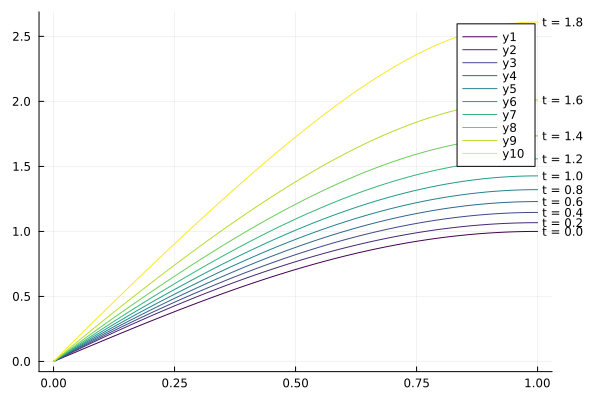

In [6]:
plt = plot()
colors = palette(:viridis,10)
for (t,c) in zip(0:0.2:1.8,colors)
    plot!(x,sol(t),color=c,right_margin=40Plots.px)
    annotate!(1.01,sol(t)[end],(f"t = {t:.1f}",8,:left))
end
plt 

Using the mass matrix can make the implementation much easier, particularly for complicated boundary conditions. Also, the algebraic variables are part of the solution, so there is no need to explicitly extend the interior values to the boundary. However, the DAE can be more difficult to solve than the equivalent IVP.; in particular, you should make sure that your initial condition does satisfy the boundary conditions.

## Rectangle

<!-- ```{code-cell}
m,n = 36,60
x,Dx,Dxx = diffmats(m,0,1)
y,Dy,Dyy = diffmats(n,-1,1)

chop(U) = U[2:m,2:n]
function extend(U) 
    last = [0;U[end-1,:];0]
    V = [ zeros(1,n+1); [zeros(m-1) U zeros(m-1)]; last' ]
    return V
end
function timederiv(U,p,t)
    U = extend(U)
    ΔU = Dxx*U + U*Dyy'
    return chop(0.2ΔU) 
end

u₀(x,y) = sin(π*x/2)*(1+y)^2*(1-y)
U₀ = [ u₀(x,y) for x in x, y in y ]
    
ivp = ODEProblem(timederiv,chop(U₀),(0,1))
sol = solve(ivp,Rodas4P(),abstol=1e-6,reltol=1e-6);
```
-->

In [7]:
m,n = 36,60
x,Dx,Dxx = diffmats(m,0,1)
y,Dy,Dyy = diffmats(n,-1,1)

function timederiv!(dU,U,p,t)
    dU .= Dxx*U + U*Dyy'
    dU[:,1] .= U[:,1]
    dU[:,end] .= U[:,end]
    dU[1,:] .= U[1,:]
    dU[end,:] .= 1.5U[end,:] - 2U[end-1,:] + 0.5U[end-2,:]
    return dU 
end

u₀(x,y) = sin(π*x/2)*(1+y)^2*(1-y)
U₀ = [ u₀(x,y) for x in x, y in y ]
    
diffl = zeros(m+1,n+1)
diffl[2:m,2:n] .= 1
∂ₜ = ODEFunction(timederiv!,mass_matrix=diagm(vec(diffl)))
ivp = ODEProblem(∂ₜ,U₀,(0,1))
sol = solve(ivp,Rodas4P(),abstol=1e-6,reltol=1e-6);

In [8]:
anim = @animate for t in range(0,1,51)
    surface(x,y,sol(t)',zlims=(0,1),clims=(0,1),
        title=f"t = {t:.2f}",size=(500,280),dpi=180)
end
mp4(anim,"heat2d.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/class/817/notes/mol/heat2d.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/driscoll/Dropbox/class/817/notes/mol/heat2d.mp4")